In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from Bio import SeqIO
import torch

In [3]:
# My modules
import utils

In [4]:
def load_chr_seq(filename):
    chr_dict = {record.id:record.seq for record in SeqIO.parse(filename, "fasta")}
    return chr_dict

def get_sequence(chrom, start, end):
    return CHR_SEQ_DICT[chrom][start:end+1]

# Get sequences (simultaneously trim long sequences to 200)
def get_sequences_and_trim(df, length):
    print("Getting " + str(len(df)) + " sequences...")
    seqs = [None]*len(df)
    l, r = 0, 0
    half = length // 2
    for i, (row_i, row) in enumerate(df.iterrows(), 0):
        before = row.summit - row.start
        after = row.end - row.summit
        if before < half:
            l = row.start
            r = row.summit + ((length-1) - before)
        elif after < half:
            l = row.summit - ((length-1) - after)
            r = row.end
        else:
            l = row.summit - half
            r = row.summit + (half-1)
        seq = get_sequence(row.seqname, l, r)
        
        bad = False
        for nt in seq:
            if nt not in ["A", "T", "G", "C"]:
                bad = True
                break
        if bad:
            df = df.drop(row_i)
            continue
                
        seqs[i] = seq
        if i % 100000 == 0:
            print("Sequences Loaded: " + str(i))
    seqs = list(filter(lambda x: x != None, seqs))
    return seqs, df

def one_hot_fixed_len(seqs, length):
    one_hot = np.zeros((len(seqs), length, 4))
    for i, seq in enumerate(seqs):
        one_hot[i] = utils.seq_to_one_hot(seq)
        if i % 100000 == 0:
            print("Sequences Converted: " + str(i))
    return one_hot

In [6]:
# get sequences from reference genome
path_to_ref_genome = "/net/seq/data/genomes/human/GRCh38/noalts/GRCh38_no_alts.fa"
CHR_SEQ_DICT = load_chr_seq(path_to_ref_genome)         # dictionary of all raw sequences

In [7]:
df = pd.read_csv('/home/meuleman/work/projects/ENCODE3/WM20180608_masterlist_FDR0.01_annotations/master_list_stats_WM20180608.txt', sep="\t")
df = df[['seqname', 'start', 'end', 'DHS_width', 'summit', 'total_signal', 'numsamples', 'numpeaks']]

nmf_vectors_df = pd.read_csv('/home/amuratov/fun/60918/60518_NNDSVD_NC16/2018-06-08NC16_NNDSVD_Mixture.csv', sep="\t")

nmf_vectors_df = nmf_vectors_df.drop('Unnamed: 0', axis=1)

test_df = pd.concat([df, nmf_vectors_df], axis=1, sort=False)

length = 100
test_df = test_df[test_df['DHS_width'] >= length]   # Filter out rows w/ dhs width < length
test_df = test_df[(test_df.total_signal.values/test_df.numsamples.values) > 0.5]

seqs, test_df = get_sequences_and_trim(test_df, length)
nmf_vectors = test_df.loc[:, 'C1':'C16'].values.astype(float)

/home/pbromley/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Getting 1431350 sequences...
Sequences Loaded: 0
Sequences Loaded: 100000
Sequences Loaded: 200000
Sequences Loaded: 300000
Sequences Loaded: 400000
Sequences Loaded: 500000
Sequences Loaded: 600000
Sequences Loaded: 700000
Sequences Loaded: 800000
Sequences Loaded: 900000
Sequences Loaded: 1000000
Sequences Loaded: 1100000
Sequences Loaded: 1200000
Sequences Loaded: 1300000
Sequences Loaded: 1400000


In [15]:
one_hot_seqs = one_hot_fixed_len(seqs, length)

Sequences Converted: 0
Sequences Converted: 100000
Sequences Converted: 200000
Sequences Converted: 300000
Sequences Converted: 400000
Sequences Converted: 500000
Sequences Converted: 600000
Sequences Converted: 700000
Sequences Converted: 800000
Sequences Converted: 900000
Sequences Converted: 1000000
Sequences Converted: 1100000
Sequences Converted: 1200000
Sequences Converted: 1300000
Sequences Converted: 1400000


In [61]:
idx_dict = {}
for i in range(16):     
    where = np.where(nmf_vectors.argmax(axis=1) == i)[0]
    where_idxs = np.argsort(nmf_vectors[where, i]/nmf_vectors[where].sum(axis=1))[::-1]
    idx_dict[i] = where[where_idxs][:20000]

In [62]:
strong_one_hot3 = np.zeros((320000, 100, 4))
strong_nmfs3 = np.zeros((320000, 16))
strong_signals3 = np.zeros((320000, 2))

total_signal = test_df.total_signal.values
mean_signal = test_df.total_signal.values / test_df.numsamples.values

place = 0
for i in range(16):
    length = 20000
    strong_one_hot3[place:place+length] = one_hot_seqs[idx_dict[i]]
    strong_nmfs3[place:place+length] = nmf_vectors[idx_dict[i]]
    strong_signals3[place:place+length][:, 0] = mean_signal[idx_dict[i]]
    strong_signals3[place:place+length][:, 1] = total_signal[idx_dict[i]]
    place += length
strong_components3 = strong_nmfs3.argmax(axis=1)

In [63]:
# Make test train splits
np.random.seed(0)
idx = np.random.permutation(len(strong_one_hot3))
one_hot_seqs_train = strong_one_hot3[idx[0:256000]]
components_train = strong_components3[idx[0:256000]]
one_hot_seqs_test = strong_one_hot3[idx[256000:]]
components_test = strong_components3[idx[256000:]]
nmf_train = strong_nmfs3[idx[0:256000]]
nmf_test = strong_nmfs3[idx[256000:]]
signals_train = strong_signals3[idx[:256000]]
signals_test = strong_signals3[idx[256000:]]

In [66]:
np.save("/home/pbromley/generative_dhs/data_numpy/strong_one_hot_train.npy", one_hot_seqs_train)
np.save("/home/pbromley/generative_dhs/data_numpy/strong_components_train.npy", components_train)
np.save("/home/pbromley/generative_dhs/data_numpy/strong_one_hot_test.npy", one_hot_seqs_test)
np.save("/home/pbromley/generative_dhs/data_numpy/strong_components_test.npy", components_test)
np.save("/home/pbromley/generative_dhs/data_numpy/strong_nmfs_train.npy", nmf_train)
np.save("/home/pbromley/generative_dhs/data_numpy/strong_nmfs_test.npy", nmf_test)
np.save("/home/pbromley/generative_dhs/data_numpy/strong_sig_train.npy", signals_train)
np.save("/home/pbromley/generative_dhs/data_numpy/strong_sig_test.npy", signals_test)

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import importlib.util
spec = importlib.util.spec_from_file_location("models", "/home/pbromley/mnist_test/models.py")
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
import seaborn as sns
from itertools import compress
from matplotlib import transforms

In [9]:
# Load pytorch modules
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.autograd as autograd
import torch.nn.functional as F

In [10]:
# Some other helpful modules
import time
from Bio.Seq import Seq
from Bio.Alphabet import single_letter_alphabet
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [11]:
import gen_models
# import gan_trainer
import data_helper
import importlib
import utils

In [12]:
import os

In [52]:
G = gen_models.snp_generator_2d_temp_2a(100, 100, 11)
G.load_state_dict(torch.load("/home/pbromley/generative_dhs/saved_models/no-condition-strong2dg-g.pth"))
G.train(False)
G.to("cuda")

snp_generator_2d_temp_2a(
  (fc): Linear(in_features=100, out_features=500, bias=True)
  (relu1): ReLU(inplace)
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up1): ConvTranspose2d(50, 100, kernel_size=(10, 1), stride=(10, 10), bias=False)
  (relu2): ReLU(inplace)
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (up2): ConvTranspose2d(100, 1, kernel_size=(11, 4), stride=(1, 1), padding=(5, 0))
  (softmax): Softmax()
)

In [96]:
def rainbow_text(x, y, strings, colors, boxes, weight, style, ax=None, outer_box=True, **kw):
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    # horizontal version
    for s, c, b, w, st in zip(strings, colors, boxes, weight, style):
        text = ax.text(x, y, s, color=c, transform=t, bbox=b, weight=w, style=st, fontsize=18, family='monospace', **kw)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units="dots")
        
    if not outer_box:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(
            axis='y',          
            which='both',       
            left=False,      
            right=False,
            labelleft=False,
        ) 
        ax.tick_params(
            axis='x',
            which='both',       
            top=False,      
            bottom=False,
            labelbottom=False
        )

def split_seq_helper(seq, c):
    s = seq.reshape(1, 1, 100, 4)
    raw_seq = utils.one_hot_to_seq(seq)
    motif = utils.get_motif_from_comp(c, ext=True)
    motif_mat = np.loadtxt("/home/pbromley/generative_dhs/memes/new_memes/" + motif)[:, np.array([0, 3, 1, 2])]
    m = utils.MotifMatch(motif_mat, where=True)
    strength, idx, strand = m(torch.from_numpy(s).float())
    col = "green"
    if strand == "-":
        idx -= (motif_mat.shape[0]-1)
        col = "red"
    
    l = max(idx, 0)
    r = min(idx+motif_mat.shape[0], 100)
    before = raw_seq[0:l]
    highlight = raw_seq[l:r]
    after = raw_seq[r:]

    high = utils.get_rough_motif_ranges()[c][1]
    low = utils.get_rough_motif_ranges()[c][0]
    strength_norm = (strength-low)/(high-low)
    strength_norm = max(strength_norm, 0)
    strength_norm = min(strength_norm, 1)
    return [(before, "black", None), (highlight, col, {'facecolor':'yellow', 'alpha':strength_norm}), (after, "black", None)]


def plot_seq(seq, c, pos):
    split = split_seq_helper(seq, c)
    l1, l2, l3 = [], [], []
    for i in range(len(split)):
        l1 += [split[i][0]]
        l2 += [split[i][1]]
        l3 += [split[i][2]]
    rainbow_text(0, 0.0206*pos, l1, l2, l3)

In [54]:
start_scans = np.zeros((16, 50))
start_zs = np.load("/home/pbromley/generative_dhs/data_numpy/fixed_zs_100.npy")
start_one_hots = G(torch.from_numpy(start_zs[:50]).float().cuda()).detach().cpu().numpy()

In [55]:
for i in range(16):
    for j in range(50):
        scan = utils.get_motif_scan(comp=i, x=start_one_hots[j])
        start_scans[i, j] = scan

In [56]:
start_seqs = [utils.one_hot_to_seq(o) for o in start_one_hots.squeeze()]

In [57]:
seq_array = []
for i in range(50):
    seq_array.append(SeqRecord(start_seqs[i], id=str(i)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/start_seqs_50.fasta", "fasta")

seq_array = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 5)).read()[:-1])
    seq_array.append(SeqRecord(seq, id=str(i)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/lymph_seqs_50.fasta", "fasta")

seq_array = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 9)).read()[:-1])
    seq_array.append(SeqRecord(seq, id=str(i)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/cardiac_seqs_50.fasta", "fasta")

seq_array = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 13)).read()[:-1])
    seq_array.append(SeqRecord(seq, id=str(i)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/digestive_seqs_50.fasta", "fasta")

seq_array = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 15)).read()[:-1])
    seq_array.append(SeqRecord(seq, id=str(i)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/hsc_seqs_50.fasta", "fasta")

seq_array = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 6)).read()[:-1])
    seq_array.append(SeqRecord(seq, id=str(i)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/neuronal_seqs_50.fasta", "fasta")

50

In [58]:
lymphs = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 5)).read()[:-1])
    lymphs.append(seq)
    
cardiacs = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 9)).read()[:-1])
    cardiacs.append(seq)
    
digestives = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 13)).read()[:-1])
    digestives.append(seq)
    
hscs = []
for i in range(50):
    seq = Seq(os.popen("tail -n 1 /home/pbromley/generative_dhs/notebooks/track/{0}-{1}.txt".format(i, 15)).read()[:-1])
    hscs.append(seq)
    
    
    


In [59]:
dref = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/digestive_out.txt", header=None, sep="\t")
cref = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/cardiac_out.txt", header=None, sep="\t")
lref = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/lymph_out.txt", header=None, sep="\t")
href = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/hsc_out.txt", header=None, sep="\t")

In [60]:
dhits = dref[2].values
chits = cref[2].values
lhits = lref[2].values
hhits = href[2].values

In [61]:
count_dict = {i:0 for i in range(50)}
for i in range(50):
    if i in dhits:
        count_dict[i] += 1
    if i in chits:
        count_dict[i] += 1
    if i in lhits:
        count_dict[i] += 1
    if i in hhits:
        count_dict[i] += 1

In [62]:
np.fromiter(count_dict.values(), int).argsort()[::-1]

array([21, 24, 41, 33, 35,  0, 46, 49, 23, 48, 26, 27, 15, 11, 10, 20,  9,
       45, 36, 37, 40,  2,  7, 13,  6,  3, 16, 17, 43, 42, 29, 38, 32, 47,
       22, 28, 14, 25, 12, 30, 19,  8, 34, 18,  5,  4, 39, 44,  1, 31])

In [82]:
hhits

array([10, 17, 24, 21, 46, 22, 35, 33, 32, 36, 15, 40, 27,  9, 49,  9])

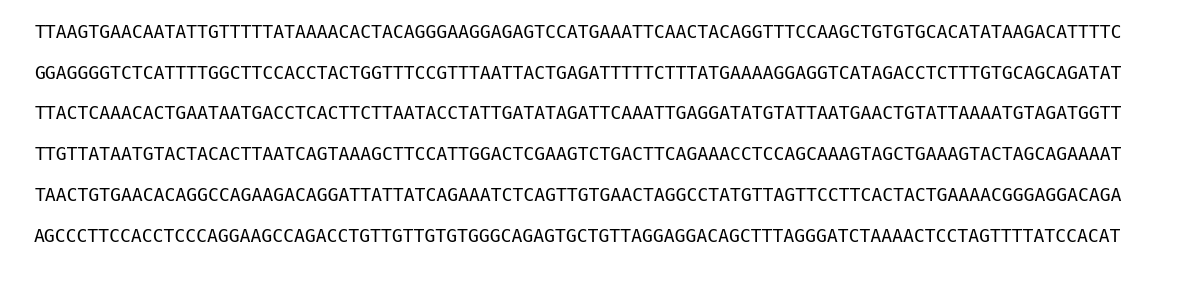

In [102]:
plt.figure(figsize=(21, 5))
for i, s in enumerate(np.array([21, 0, 6, 33, 9, 27])):
    rainbow_text(0.02, 0.15 + i*0.15, [start_seqs[s]], ["black"], [None], [None], ['normal'], outer_box=False)
# rainbow_text(0.02, 0.15 + 5*0.15, [start_seqs[46][:74], start_seqs[46][74:86], start_seqs[46][86:]], 
#              ["black", "black", "black"], [None, {'facecolor':utils.get_dhs_colors()[8], 'alpha':0.5}, None],
#              [None, 'extra bold', None], ['normal', 'italic', 'normal'])
plt.savefig("/home/pbromley/generative_dhs/figures/optimized/start_seqs.pdf", format='pdf', bbox_inches='tight')

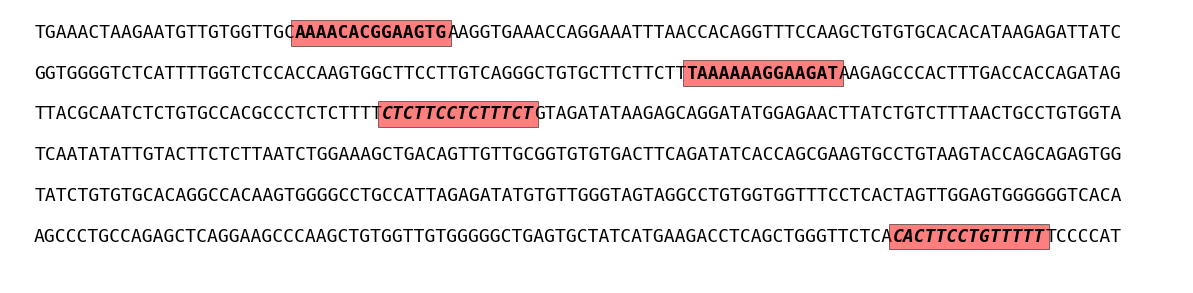

In [107]:
c = 14
plt.figure(figsize=(21, 5))
for i, s in enumerate(np.array([21, 0, 6, 33, 9, 27])):
    if c == 12:
        seq = digestives[s]
        ref = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/digestive_out.txt", header=None, sep="\t")
        save_lab = "digestive"
    elif c == 8:
        seq = cardiacs[s]
        ref = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/cardiac_out.txt", header=None, sep="\t")
        save_lab = "cardiac"
    elif c == 14:
        seq = hscs[s]
        ref = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/hsc_out.txt", header=None, sep="\t")
        save_lab = "myeloid"
    else:
        seq = lymphs[s]
        ref = pd.read_csv("/home/pbromley/generative_dhs/memes/new_memes/lymph_out.txt", header=None, sep="\t")
        save_lab = "lymph"
    idxs = ref[2].values
    idx = np.where(idxs == s)[0]
    if idx.shape[0] == 0:
        seqs = [seq]
        highlights = [None]
        weights = [None]
        style = ['normal']
    else:
        idx = idx[0]
        seq_range = (ref[3][idx]-1, ref[4][idx])
        strand = ref[5][idx]
        if strand == "+":
            st = 'normal'
        else:
            st = "italic"
        seqs = [seq[:seq_range[0]], seq[seq_range[0]:seq_range[1]], seq[seq_range[1]:]]
        colors = ["black", "black", "black"]
        highlights = [None, {'facecolor':utils.get_dhs_colors()[c], 'alpha':0.5}, None]
        weights = [None, 'extra bold', None]
        style = ['normal', st, 'normal']
    
    rainbow_text(0.02, 0.15 + i*0.15, seqs, colors, highlights, weights, style, outer_box=False)
    plt.savefig("/home/pbromley/generative_dhs/figures/optimized/{0}_seqs.pdf".format(save_lab), format='pdf', bbox_inches='tight')

In [8]:
seq_hist_dict = {k:[] for k in range(16)}
for i in range(200):
    for j in range(16):
        seq_hist_dict[j].append([])
    

for i in range(200):
    for j in np.arange(1, 17):
        with open("track2/for-deltas-{0}-{1}.txt".format(i, j), "r") as f:
            for k in range(200):
                seq_hist_dict[j-1][k].append(Seq(f.readline()[:-1])) 

        

In [9]:
oh_seq_hist_dict = {k:np.zeros((200, 200, 100, 4)) for k in range(16)}

for key, val in seq_hist_dict.items():
    for i in range(len(val)):
        oh_seq_hist_dict[key][i] = np.array([utils.seq_to_one_hot(s) for s in val[i]])



In [10]:
during_dict = {k:np.zeros((200, 200)) for k in range(16)}

for i in range(16):
    for j in range(200):
        during_dict[i][j] = utils.get_motif_scan(comp=i, x=oh_seq_hist_dict[i][j])

In [11]:
delta_dict = {k:np.zeros((200, 200)) for k in range(16)}

for i in range(16):
    for j in range(200):
        delta_dict[i][j] = during_dict[i][j] - during_dict[i][0]

In [23]:
for i in range(0, 200):
    plt.figure(figsize=(10, 15))
    ax = plt.subplot(111)
    ax.barh([-1], (0.3/200)*i, color='black', height=0.3)
    ax.barh([-1], 0.3, color='black', height=0.3, fill=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.tick_params(
        axis='y',          
        which='both',       
        left=False,      
        right=False,
        labelleft=False,
    ) 
    ax.tick_params(axis='x',
                   labelsize=16)
    ax.set_xlim(-0.05, 0.302)
    ax.set_xticklabels(["-5%", "0", "+5%", "+10%", "+15%", "+20%", "+25%", "+30%"])
    for it, j in enumerate((utils.get_order()-1)[::-1]):
        plt.barh([it+1], (delta_dict[j][i]/during_dict[j][0]).mean(), color=utils.get_dhs_colors()[j])
    plt.savefig("/home/pbromley/generative_dhs/optimization_figures/motif_anim_ms/{0}".format(i))
    plt.close()

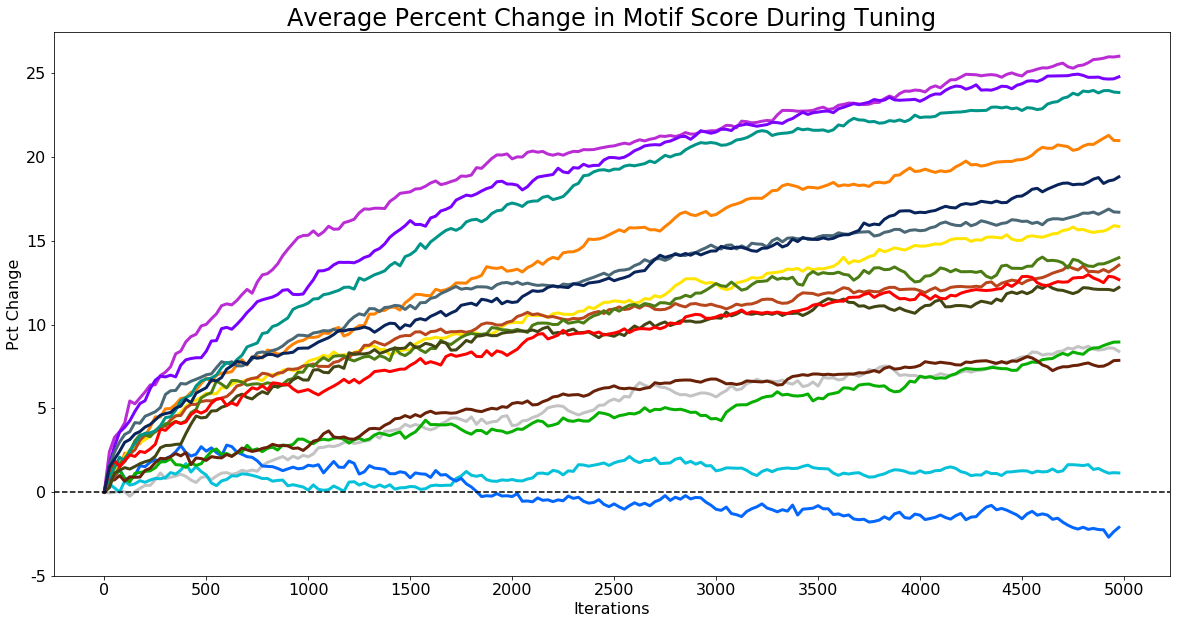

In [21]:
plt.figure(figsize=(20, 10))
for i in range(16):
    plt.plot(np.arange(200), (delta_dict[i]/during_dict[i][0]).mean(1), c=utils.get_dhs_colors()[i], linewidth=3)
plt.title("Average Percent Change in Motif Score During Tuning", fontsize=24)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Pct Change", fontsize=16)
plt.yticks(np.arange(-0.05, 0.30, 0.05), np.arange(-5, 30, 5), fontsize=16)
plt.xticks(np.arange(0, 220, 20), np.arange(0, 5500, 500), fontsize=16)
plt.axhline(0, linestyle="--", c="black")
plt.savefig("/home/pbromley/generative_dhs/figures/optimized/pct_change_over_time_ms.pdf", format="pdf")

In [14]:
real_seqs_oh = np.load("/home/pbromley/generative_dhs/data_numpy/strong_one_hot_train.npy")
comps = np.load("/home/pbromley/generative_dhs/data_numpy/strong_components_train.npy")
scores = []
for i in range(16):
    scores.append(utils.get_motif_scan(x=real_seqs_oh[comps == i], comp=i).tolist())
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [15]:
cutoffs = []
for i in range(16):
    scores[i].sort()
    cut = np.floor(0.95 * len(scores[i])).astype(int)
    cutoffs.append(scores[i][cut])

In [16]:
cutoffs

[9.119519233703613,
 7.411408424377441,
 9.342591285705566,
 7.367074489593506,
 10.13344955444336,
 9.269439697265625,
 6.963345050811768,
 6.22803258895874,
 8.997139930725098,
 9.352072715759277,
 9.553133964538574,
 7.487240791320801,
 11.121925354003906,
 8.515666007995605,
 10.606958389282227,
 11.446775436401367]

In [17]:
final_scans = np.zeros((16, 200))
for i in range(16):
    final_scans[i] = during_dict[i][-1]

In [18]:
above = np.zeros(16)
for i in range(16):
    above[i] = (final_scans[i] > cutoffs[i]).sum()/len(final_scans[i])

In [19]:
log2s = np.log2(above[utils.get_order()-1]/0.05)

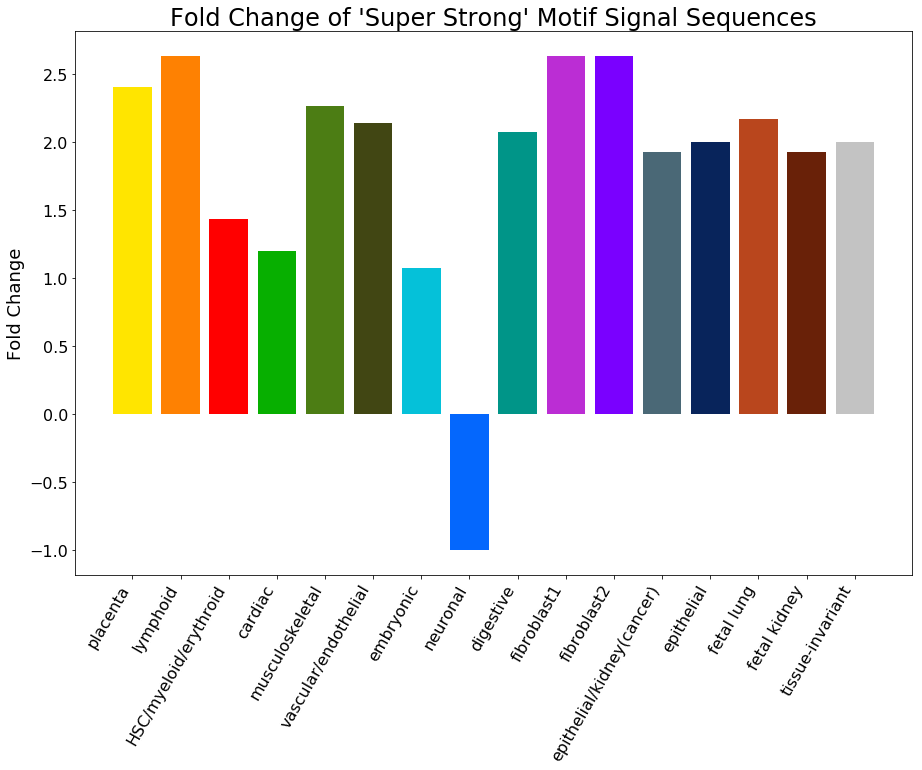

In [22]:
plt.figure(figsize=(15, 10))
plt.bar(np.arange(16), log2s, color=utils.get_dhs_colors()[utils.get_order()-1])
plt.xticks(np.arange(16), utils.get_component_class_names(), fontsize=16, rotation=60, ha='right')
plt.yticks(fontsize=16)
plt.ylabel("Fold Change", fontsize=18)
plt.title("Fold Change of 'Super Strong' Motif Signal Sequences", fontsize=24)
plt.savefig("/home/pbromley/generative_dhs/figures/optimized/fold_change_ms.pdf", format='pdf', bbox_inches='tight')

In [113]:
test = [utils.one_hot_to_seq(o) for o in np.load('/home/pbromley/generative_dhs/optimized/nz100/seqs-9.npy')]
seq_array = []
for i in range(50):
    seq_array.append(SeqRecord(test[i], id=str(i)))
SeqIO.write(seq_array, "/home/pbromley/generative_dhs/memes/new_memes/cardiac_test.fasta", "fasta")



50